In [1]:
import numpy as np
import pandas as pd
from edempy import Deck
from extrapolation import extrapolation
from LaceyClass import LaceyMixingAnalyzer
import matplotlib.pyplot as plt
from rnn.data_loader_rnn import RNNLoader
from rnn.rnn_extrap import plot_particles, import_dict
import matplotlib.pyplot as plt
import math


sim_names = ["Rot_drum_mono", "Rot_drum_binary_mixed", "Rot_drum_400k"]
sim_name = sim_names[-1]
sim_path =rf"V:\GrNN_EDEM-Sims\{sim_name}.dem"

In [2]:
daor_settings = f"{sim_path[:-4]}_data\Export_Data\Dynamic_angle_of_repose_analyst_settings.txt"

with open(daor_settings, 'r') as file:
    preferences=file.readlines()
    sim_end=float(preferences[3])
    domain=np.array(preferences[5].split(','))
    domain=domain.astype('float64')
    bin_size=np.array(preferences[7].split(','))
    bin_size=bin_size.astype('float64')
    interval=np.array(preferences[9].split(','))
    interval=interval.astype('float64')
    report=str(preferences[11])
    summary=str(preferences[13])
    plots=str(preferences[15])
    file.close()
    settings=True

grid_x=np.linspace(domain[0],domain[1],int((domain[1]-domain[0])/bin_size[0]))
grid_y=np.linspace(domain[2],domain[3],int((domain[3]-domain[2])/bin_size[1]))

In [62]:
start_t = 1
end_t = 20
domain_x = (-0.07, 0.07)       
domain_y = (-0.025, 0.025)
domain_z = (-0.07, 0.03)
num_bins = 10
direction = "y"

extrap = extrapolation(start_t, end_t, sim_path, domain_x, domain_y, domain_z, num_bins, direction)

In [3]:
delta_t = 0.05
extrapolated_time = []
delta_means = []
delta_stds = []
delta_covs = []
id_dict_path = rf"V:\GrNN_EDEM-Sims\{sim_name}_data\Export_Data"
id_dict = import_dict(id_dict_path, "id_dict")
plots_path = rf"{sim_path[:-4]}_data\Export_Data\extrap_algo_plots"

# for timestep in np.arange(rnn.start_t, rnn.end_t+delta_t, delta_t):
#     timestep_i = rnn.find_nearest(timestep, rnn.deck.timestepValues)
#     print(timestep_i)

#     delta=np.zeros(len(grid_y))
#     index_nonzero=np.zeros(len(grid_x))
#     SurfaceZ=np.zeros(shape=(len(grid_y),len(grid_x)))
#     SurfaceY=np.zeros(shape=(len(grid_y),len(grid_x)))
#     SurfaceX=np.zeros(shape=(len(grid_y),len(grid_x)))
#     Coord=extrap.get_particle_coords(timestep_i)[:,:3]

#     for i in range(len(grid_y)):
#     #Find surface particles
#         for j in range (len(grid_x)):
#             index_coord=np.where((Coord[:,0]>(grid_x[j]-bin_size[0]/2)) & (Coord[:,0]<(grid_x[j]+bin_size[0]/2)) & (Coord[:,1]>(grid_y[i]-bin_size[1]/2)) & (Coord[:,1]<(grid_y[i]+bin_size[1]/2)))
#             surf=Coord[index_coord]
#             #Index zero values and get surface particles
#             if surf.shape[0]>0:
#                 Max=np.argmax(surf[:,2])
#                 SurfaceX[i][j]=surf[Max,0]
#                 SurfaceY[i][j]=surf[Max,1]
#                 SurfaceZ[i][j]=surf[Max,2]
#                 index_nonzero[j]=j
#             else:
#                 index_nonzero[j]=-1
#         #Linear fit to surface particles
#         fit=np.polyfit(grid_x[index_nonzero!=-1],SurfaceZ[i][index_nonzero!=-1],1)
#         #Calculating angle of repose and statistics
#         delta[i]=math.atan(abs(fit[0]))*180/math.pi

    
#     delta_mean = np.average(delta)
#     delta_std = np.std(delta)
#     delta_cov = delta_std/delta_mean*100

#     delta_means.append(delta_mean)
#     delta_stds.append(delta_std)
#     delta_covs.append(delta_cov)

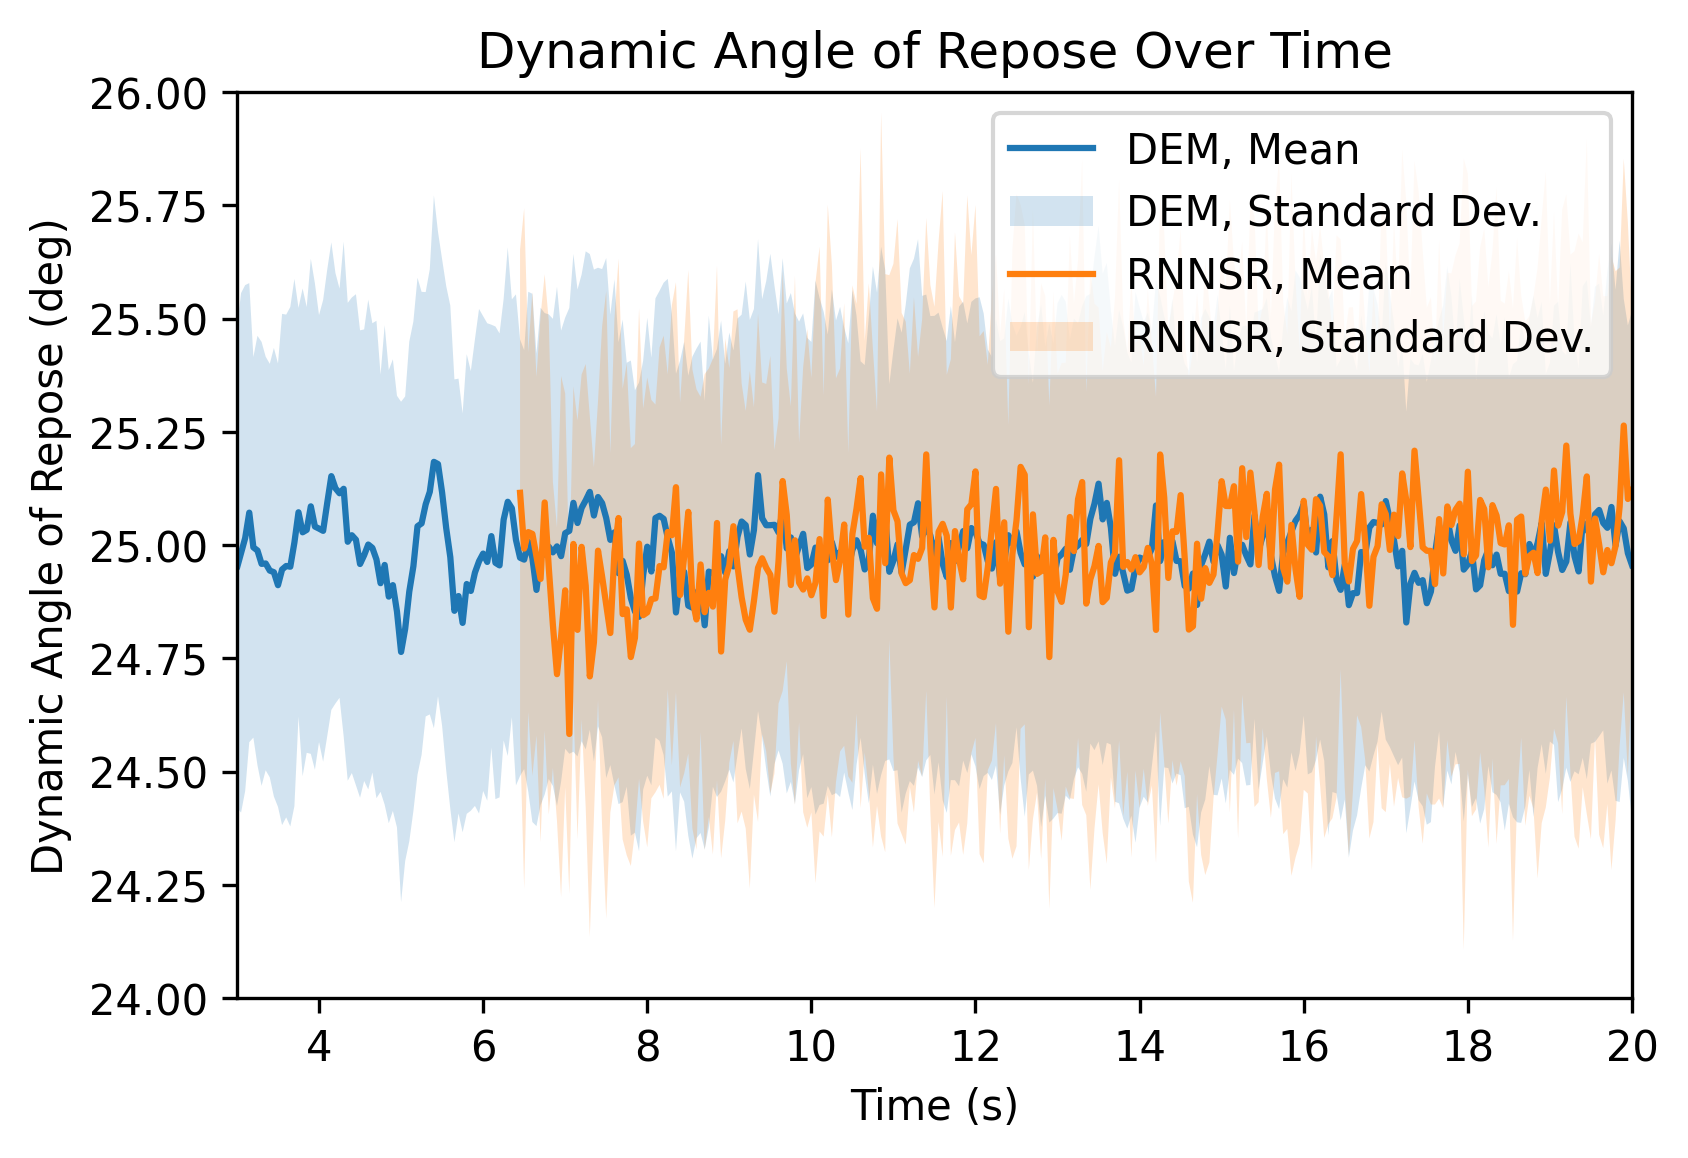

In [28]:
dem_daor_path = rf"V:\GrNN_EDEM-Sims\{sim_name}_data\Export_Data\dem_sim_plots\actual_DAoR.csv"
dem_daor = np.genfromtxt(dem_daor_path, delimiter=",")

rnnsr_daor_path =  rf"V:\GrNN_EDEM-Sims\{sim_name}_data\Export_Data\RNNSR_plots\35_12_35_sl15_3_6.5_0.05s_plots_30ep_128batch\_DAoR.csv"
rnnsr_daor = np.genfromtxt(rnnsr_daor_path, delimiter=",")

mean_dem = dem_daor[:, 1]
std_dev_dem = dem_daor[:, 2]

mean_rnnsr = rnnsr_daor[:, 1]
std_dev_rnnsr = rnnsr_daor[:, 2]

# Plot the mean data
plt.figure(dpi=300)
plt.plot(dem_daor[:, 0], mean_dem, label='DEM, Mean')

# Plot the error area
plt.fill_between(dem_daor[:, 0], mean_dem - std_dev_dem, mean_dem + std_dev_dem, alpha=0.2, label='DEM, Standard Dev.')

plt.plot(rnnsr_daor[:, 0], mean_rnnsr, label='RNNSR, Mean')

# Plot the error area
plt.fill_between(rnnsr_daor[:, 0], mean_rnnsr - std_dev_rnnsr, mean_rnnsr + std_dev_rnnsr, alpha=0.2, label='RNNSR, Standard Dev.')

plt.xlim(left=3, right=20)
plt.ylim(bottom=24, top=26)

# Add labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Dynamic Angle of Repose (deg)')
plt.title('Dynamic Angle of Repose Over Time')
plt.legend()

plt.show()

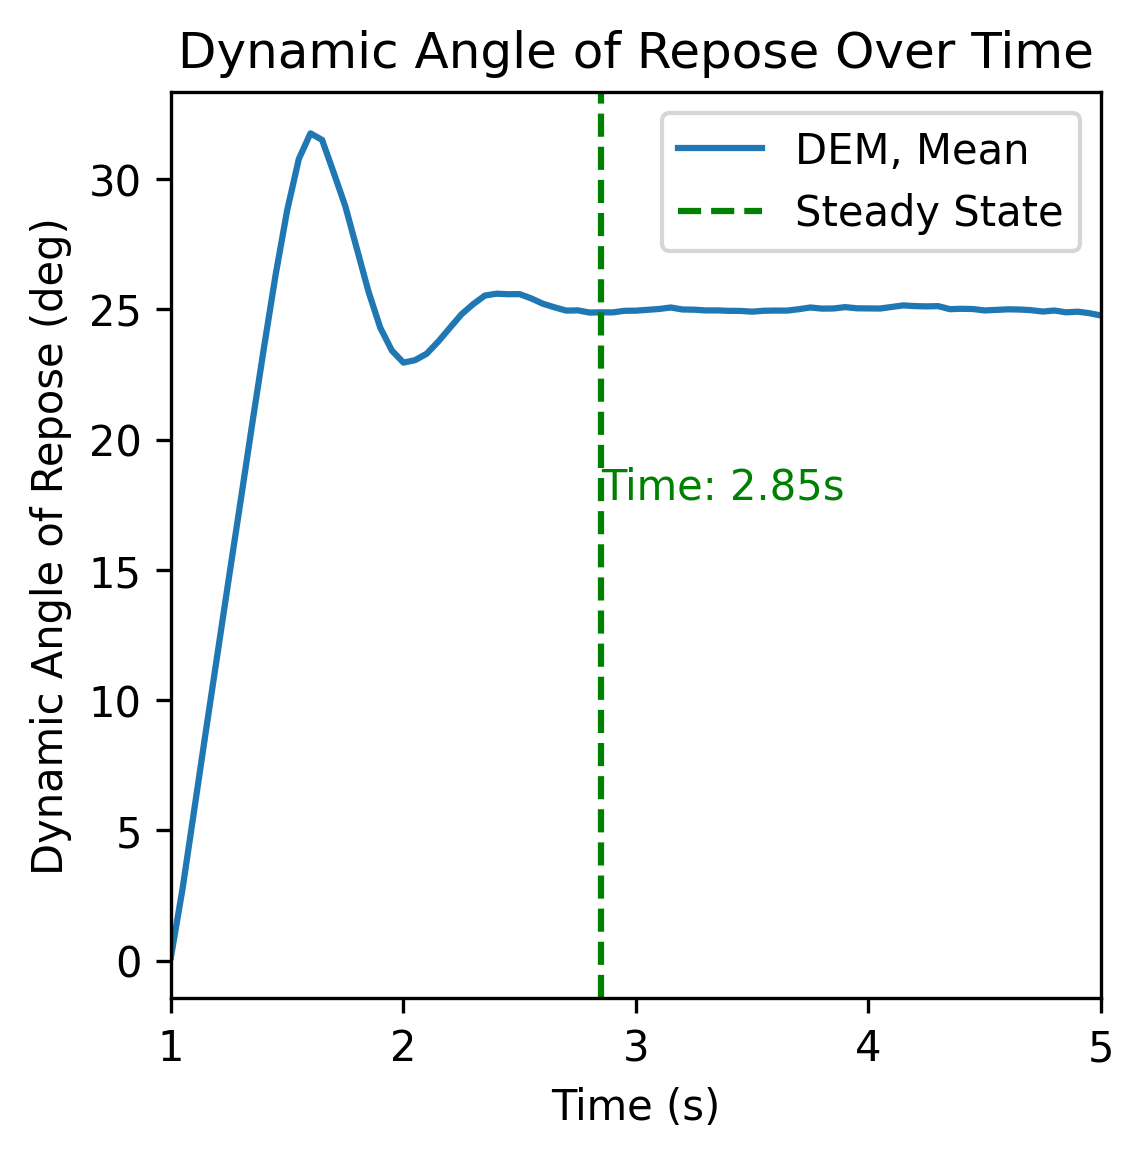

In [123]:
dem_daor_path = rf"V:\GrNN_EDEM-Sims\{sim_name}_data\Export_Data\dem_sim_plots\actual_DAoR.csv"
dem_daor = np.genfromtxt(dem_daor_path, delimiter=",")

mean_dem = dem_daor[:, 1]
std_dev_dem = dem_daor[:, 2]

threshold = 0.001  # Adjust the threshold based on your specific case

# Find the index where the kinetic energies stabilize
kin_diff = np.abs(np.diff(dem_daor[:, 1]))

steady_state_index = np.argmax(kin_diff < threshold)

# Plot the mean data
plt.figure(figsize=(4,4), dpi=300)
plt.plot(dem_daor[:, 0], mean_dem, label='DEM, Mean')

# Plot the error area
#plt.fill_between(dem_daor[:, 0], mean_dem - std_dev_dem, mean_dem + std_dev_dem, alpha=0.2, label='DEM, Standard Dev.')

steady_state_value = dem_daor[steady_state_index, 0]
# Plot vertical line at steady state
plt.axvline(x=steady_state_value, color='green', linestyle='--', label='Steady State')
plt.text(steady_state_value, (plt.ylim()[1]-plt.ylim()[0])/2, f'Time: {steady_state_value:.2f}s', verticalalignment='bottom', color="green")


plt.xlim(left=1, right=5)
# plt.ylim(bottom=24, top=26)

# Add labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Dynamic Angle of Repose (deg)')
plt.title('Dynamic Angle of Repose Over Time')
plt.legend()

plt.show()

In [61]:
from edempy import Deck

deck = Deck(sim_path)

In [66]:
times = []
mean_ang_vels= []

for timestep in np.arange(extrap.start_t, extrap.end_t+delta_t, delta_t):
    timestep_i = extrap.find_nearest(timestep, extrap.deck.timestepValues)
    ang_vels = deck.timestep[timestep_i].particle[0].getAngularVelocities()
    mean_ang_vels.append(np.mean(ang_vels))

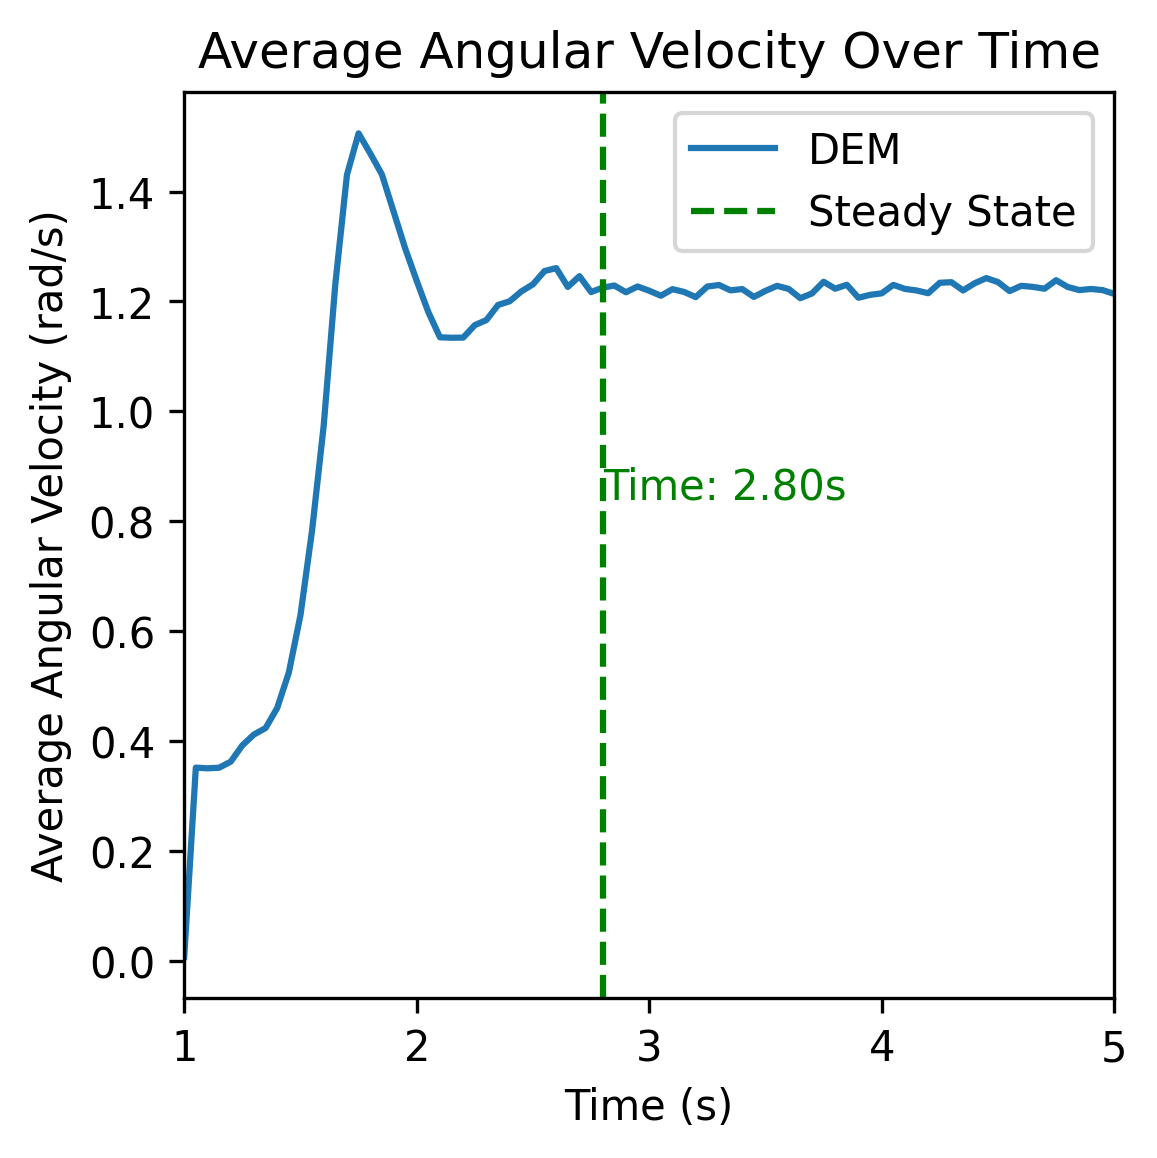

In [117]:
# Plot the mean data
plt.figure(figsize=(4, 4), dpi=300)


threshold = 0.005  # Adjust the threshold based on your specific case
adjust = 25
# Find the index where the kinetic energies stabilize
kin_diff = np.abs(np.diff(mean_ang_vels[adjust:]))

steady_state_index = np.argmax(kin_diff < threshold)

times = np.arange(1,20.05,0.05)

plt.plot(times, -1*np.array(mean_ang_vels), label='DEM')
#plt.plot(times[adjust+1:], kin_diff, label='DEM')

steady_state_value = times[adjust:][steady_state_index]
# Plot vertical line at steady state
plt.axvline(x=steady_state_value, color='green', linestyle='--', label='Steady State')
plt.text(steady_state_value, (plt.ylim()[1]-plt.ylim()[0])/2, f'Time: {steady_state_value:.2f}s', verticalalignment='bottom', color="green")


plt.xlim(left=1, right=5)
# plt.ylim(bottom=24, top=26)

# Add labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Average Angular Velocity (rad/s)')
plt.title('Average Angular Velocity Over Time')
plt.legend()

plt.show()

In [80]:
kin_diff

array([3.44692469e-01, 1.25626316e-03, 1.03870152e-03, 1.10087849e-02,
       2.96964899e-02, 1.98281739e-02, 1.16701156e-02, 3.66430974e-02,
       6.44037339e-02, 1.04465587e-01, 1.54273959e-01, 1.90979293e-01,
       2.57580021e-01, 1.98761477e-01, 7.54397476e-02, 3.64894743e-02,
       3.80168719e-02, 6.71245539e-02, 6.71515656e-02, 5.96588241e-02,
       5.69096728e-02, 4.59329563e-02, 7.54365912e-04, 2.28201183e-04,
       2.27440801e-02, 9.25470685e-03, 2.74915754e-02, 6.66897384e-03,
       1.79078990e-02, 1.29391208e-02, 2.42046476e-02, 5.29538860e-03,
       3.42217890e-02, 1.95665617e-02, 2.89150481e-02, 8.02744184e-03,
       3.81542357e-03, 1.21712782e-02, 1.04513893e-02, 7.71407628e-03,
       9.09182850e-03, 1.18907378e-02, 4.97827805e-03, 9.47036842e-03,
       1.92526653e-02, 2.84042985e-03, 9.79938459e-03, 2.40774900e-03,
       1.43492728e-02, 1.10179507e-02, 9.14006699e-03, 5.61113271e-03,
       1.68577204e-02, 8.64415724e-03, 2.12448347e-02, 1.25537231e-02,
      

In [124]:
import numpy as np
from scipy.optimize import linear_sum_assignment

# Define the cost matrix
cost_matrix = np.array([
    [0.21, 0.28, 0.57, 0.37],
    [0.31, 0.53, 0.67, 0.12],
    [0.53, 0.22, 0.99, 0.56],
    [0.43, 0.24, 0.59, 0.14]
])

# Use linear sum assignment to find optimal pairs
row_indices, col_indices = linear_sum_assignment(cost_matrix)

# Print optimal pairs
for row, col in zip(row_indices, col_indices):
    print(f'xA,{row+1} with x{chr(ord("A")+col)},2')


xA,1 with xA,2
xA,2 with xD,2
xA,3 with xB,2
xA,4 with xC,2


In [126]:
col_indices

array([0, 3, 1, 2], dtype=int64)